In [254]:
import numpy as np
import bm3d
from pathlib import Path
import pickle
from skimage import io, img_as_float
import nibabel as nib
import os
import glob
from collections import defaultdict

File Paths

In [255]:
icip_data = "D:/VIP Cup/Dataset/ICIP training data/"
denoised_pkl_dataset = "D:/VIP Cup/Output dataset/pkl_data"
final_denoised_dataset = "D:/VIP Cup/Output dataset/final_pipeline_denoised_tiff_dataset"


Constants

In [256]:
tiff_directories = defaultdict(int)
denoised_tiff_count = 0
original_tiff_count = 0
SIGMA = 30
oct_height = 300
oct_width = 300

Functions to check whether a tiff file/directory or not

In [257]:
def is_tiff_dir(curr_path):
    '''function to check if the current directory having any tiff files'''
    num_tiff = len(glob.glob(os.path.join(curr_path, '*.tiff')))
    return num_tiff

def is_tiff(curr_path):
    '''function to check if the current file is a tiff file or not'''
    if os.path.isfile(curr_path) and (".tiff" in curr_path):
        return True
    else:
        return False

Searching tiff directories

In [258]:
tiff_directories = defaultdict(int)
denoised_tiff_count = 0
original_tiff_count = 0
SIGMA = 0.083

dataset = glob.iglob(os.path.join(icip_data, '**'), recursive=True)

for i,file in enumerate(dataset):
    if is_tiff_dir(file):

        current_tiff_count = is_tiff_dir(file)
        tiff_directories[file] = current_tiff_count
        print(f"{len(tiff_directories)}th case {file} ......")
        original_tiff_count += current_tiff_count



print(f"Denoised cases: {len(tiff_directories)}")
#print(f"Denoised tiff images: {denoised_tiff_count}")
print(f"Original tiff images: {original_tiff_count}")


1th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (1) ......
2th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (10) ......
3th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (11) ......
4th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (12) ......
5th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (13) ......
6th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (14) ......
7th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (15) ......
8th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (16) ......
9th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (17) ......
10th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (18) ......
11th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (19) ......
12th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (2) ......
13th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (20) ......
14th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (21) ......
15t

Denoising Function

In [259]:
import numpy as np
from numpy.linalg import svd
from PIL import Image
import math
import cv2

def get_svd_image(image_path):
    # Open the tiff image

    # Convert the image to a NumPy array
    A = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Remember image size
    n = len(A)

    # Take SVD
    U, S, V = svd(A)

    threshold = 4/np.sqrt(3)
    filter = (S > threshold)*1 
    filtered_S = np.multiply(S, filter)

    # Initialize blank image
    final_img = np.zeros((n, n))
    
    for i in range(n):
        matrix = S[i]*np.outer(U[:,i],V[i])
        final_img += matrix
    
    return final_img

In [260]:
import numpy as np
from numpy.linalg import svd
from PIL import Image
import math

def get_svd_image_from_array(A):

    # Remember image size
    n = len(A)

    # Take SVD
    U, S, V = svd(A)

    threshold = 4/np.sqrt(3)
    filter = (S > threshold)*1 
    filtered_S = np.multiply(S, filter)

    # Initialize blank image
    final_img = np.zeros((n, n))
    
    for i in range(n):
        matrix = S[i]*np.outer(U[:,i],V[i])
        final_img += matrix
    
    return final_img

In [261]:
def open_noisy_image_as_array(image_path):
    image_array = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return np.array(image_array)

In [262]:
def bm3d_denoise(noisy_image, npsd_sigma=SIGMA):

    noisy_oct = cv2.imread(noisy_image, cv2.IMREAD_GRAYSCALE)
    sigma = npsd_sigma
    bm3d_denoised = bm3d.bm3d(noisy_oct, sigma_psd=sigma, stage_arg=bm3d.BM3DStages.ALL_STAGES)
    return bm3d_denoised

In [263]:
def bm3d_denoise_from_image_array(noisy_image_array, npsd_sigma = SIGMA):

    sigma = npsd_sigma
    bm3d_denoised = bm3d.bm3d(noisy_image_array, sigma_psd=sigma, stage_arg=bm3d.BM3DStages.ALL_STAGES)
    return bm3d_denoised

Evaluation Metrics

In [264]:
from skimage import exposure as ex
from skimage.filters import threshold_otsu
from skimage.morphology import convex_hull_image
import numpy as np

def get_foreground_mask(img_array, save_folder=None):

    img = bm3d_denoise_from_image_array(img_array, npsd_sigma=32)

    
    # Histogram equalization
    h = ex.equalize_hist(img[:,:]) * 255
    
    # Thresholding using Otsu's method on original image
    oi = np.zeros_like(img, dtype=np.uint16)
    oi[(img > threshold_otsu(img))] = 1
    
    # Thresholding using Otsu's method on histogram equalized image
    oh = np.zeros_like(img, dtype=np.uint16)
    oh[(h > threshold_otsu(h))] = 1
    
    # Calculate weights based on the percentage of pixels above Otsu's threshold
    nm = img.shape[0] * img.shape[1]
    w1 = np.sum(oi) / nm
    w2 = np.sum(oh) / nm
    
    # Combine images using weighted sum
    ots = np.zeros_like(img, dtype=np.uint16)
    new = (w1 * img) + (w2 * h)
    ots[(new > threshold_otsu(new))] = 1 
    
    # Compute convex hull of the thresholded image
    conv_hull = convex_hull_image(ots)
    
    # Convert convex hull to binary (0 or 1)
    ch = np.multiply(conv_hull, 1)
    
    return ch

In [265]:
def get_foreground_background(image_array, foreground_mask):
    fore_img = foreground_mask*image_array
    back_img = (1-foreground_mask)*image_array
    return fore_img, back_img


In [266]:
import numpy as np

def calculate_absolute_cnr(foreground, background):
    # Convert images to float arrays for numerical operations
    foreground = foreground.astype(np.float64)
    background = background.astype(np.float64)
    
    # Calculate mean intensities
    mean_foreground = np.mean(foreground)
    mean_background = np.mean(background)
    
    # Calculate standard deviations
    std_foreground = np.std(foreground)
    std_background = np.std(background)
    
    # Calculate contrast-to-noise ratio (CNR)
    numerator = np.abs(mean_foreground - mean_background)
    denominator = np.sqrt((std_foreground**2 + std_background**2) / 2)
    cnr = 10*np.log10(numerator / denominator)
    
    return cnr

In [267]:
def calculate_msr(fore_ground_data):
    """
    Calculate Mean-to-Standard Deviation Ratio (MSR) of a dataset.

    Parameters:
    - data: NumPy array or list, input dataset

    Returns:
    - msr: float, Mean-to-Standard Deviation Ratio
    """
    # Compute mean and standard deviation of the data

    mean_val = np.mean(fore_ground_data)
    std_dev = np.std(fore_ground_data)
    
    # Calculate MSR (mean-to-standard deviation ratio)
    if std_dev != 0:
        msr = mean_val / std_dev
    else:
        msr = float('inf')  # Handle division by zero case
    
    return msr

In [268]:
def eval_image(image_array, foreground_mask):
    # Get foreground and background images
    foreground, background = get_foreground_background(image_array, foreground_mask=foreground_mask)
    
    # Calculate CNR
    cnr = calculate_absolute_cnr(foreground, background)
    
    # Calculate MSR
    msr = calculate_msr(foreground)
    
    return cnr, msr

In [269]:
test_im_path = "D:/VIP Cup/Dataset/ICIP training data/1/RawDataQA-1 (21)/RawDataQA-1-21 (66).tiff"

raw_image: CNR: 2.7341571583341704, MSR: 1.935994191109229

bm3d_denoised: CNR: 2.87656042305707, MSR: 2.0198372758621717

svd_denoised: CNR: 2.7341571583341695, MSR: 1.935994191109229

pipeline_denoised: CNR: 2.8765604230570685, MSR: 2.0198372758621717



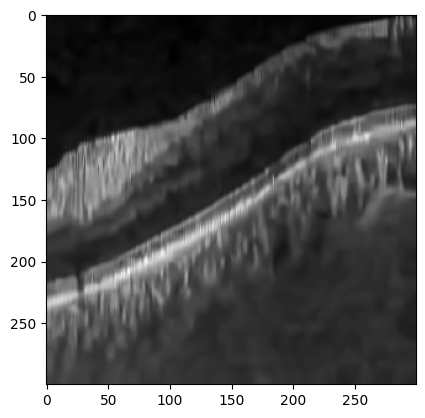

In [270]:
from matplotlib import pyplot as plt

raw_image = open_noisy_image_as_array(test_im_path)

mask = get_foreground_mask(raw_image)

raw_image = open_noisy_image_as_array(test_im_path)
cnr, msr = eval_image(raw_image,mask)
print(f"raw_image: CNR: {cnr}, MSR: {msr}")
plt.imshow(raw_image,cmap='gray')
print()

bm3d_denoise_image = bm3d_denoise(test_im_path, 29)
cnr, msr = eval_image(bm3d_denoise_image,mask)
print(f"bm3d_denoised: CNR: {cnr}, MSR: {msr}")
plt.imshow(bm3d_denoise_image,cmap='gray')
print()

svd_image = get_svd_image(test_im_path)
cnr, msr = eval_image(svd_image,mask)
print(f"svd_denoised: CNR: {cnr}, MSR: {msr}")
plt.imshow(svd_image,cmap='gray')
print()


pipelined_image = get_svd_image_from_array(bm3d_denoise_image)
cnr, msr = eval_image(pipelined_image,mask)
print(f"pipeline_denoised: CNR: {cnr}, MSR: {msr}")
plt.imshow(pipelined_image,cmap='gray')
print()

In [271]:
pipelined_image.shape

(300, 300)

In [272]:
kif_oct_path = "D:/VIP Cup/Dataset/ICIP training data/1/RawDataQA-1 (21)/RawDataQA-1-21 (66).tiff"

In [273]:
def find_sigma(test_image, sigma):
    
    raw_image = open_noisy_image_as_array(test_image)
    bm3d_denoised_image = bm3d_denoise(test_image, npsd_sigma=sigma)
    cnr, msr = eval_image(bm3d_denoised_image)
    print(f"bmsd denoised_image: CNR: {cnr}, MSR: {msr}")

    import matplotlib.pyplot as plt

    # Plot the noisy raw image
    plt.subplot(1, 2, 1)
    plt.imshow(raw_image, cmap='gray')
    plt.title('Noisy Raw Image')

    # Plot the BM3D denoised image
    plt.subplot(1, 2, 2)
    plt.imshow(bm3d_denoised_image, cmap='gray')
    plt.title('BM3D Denoised Image')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

In [274]:
for sigma in range(24,34):
    print(f"sigma: {sigma}")
    find_sigma(kif_oct_path, sigma)

sigma: 24


TypeError: eval_image() missing 1 required positional argument: 'foreground_mask'

In [ ]:
tiff_directories

defaultdict(int,
            {'D:/VIP Cup/Dataset/ICIP training data\\0\\RawDataQA (1)': 52,
             'D:/VIP Cup/Dataset/ICIP training data\\0\\RawDataQA (10)': 273,
             'D:/VIP Cup/Dataset/ICIP training data\\0\\RawDataQA (11)': 300,
             'D:/VIP Cup/Dataset/ICIP training data\\0\\RawDataQA (12)': 258,
             'D:/VIP Cup/Dataset/ICIP training data\\0\\RawDataQA (13)': 146,
             'D:/VIP Cup/Dataset/ICIP training data\\0\\RawDataQA (14)': 220,
             'D:/VIP Cup/Dataset/ICIP training data\\0\\RawDataQA (15)': 87,
             'D:/VIP Cup/Dataset/ICIP training data\\0\\RawDataQA (16)': 52,
             'D:/VIP Cup/Dataset/ICIP training data\\0\\RawDataQA (17)': 176,
             'D:/VIP Cup/Dataset/ICIP training data\\0\\RawDataQA (18)': 300,
             'D:/VIP Cup/Dataset/ICIP training data\\0\\RawDataQA (19)': 84,
             'D:/VIP Cup/Dataset/ICIP training data\\0\\RawDataQA (2)': 201,
             'D:/VIP Cup/Dataset/ICIP training data\\

Denoising evaluating Pipeline

In [278]:
# denoising pipeline for denoise the tiff images in each and every tiff directories
def denoising_evaluation_pipeline(tiff_directories):
    '''denoising pipeline for denoise the tiff images in each and every tiff directories'''
    count = 0

    cnrs = {"raw": [], "bm3d": [], "svd": [], "pipeline": []}
    msrs = {"raw": [], "bm3d": [], "svd": [], "pipeline": []}

    for i, tiff_dir in enumerate(tiff_directories):
        print(f"{i}th case {tiff_dir} ......")

        tiff_files = os.listdir(tiff_dir)

        if len(tiff_files) == tiff_directories[tiff_dir]:
            for tiff_file in tiff_files[20:25]:
                tiff_file_path = os.path.join(tiff_dir, tiff_file)
                raw_image = open_noisy_image_as_array(tiff_file_path)

                mask = get_foreground_mask(raw_image)

                raw_image = open_noisy_image_as_array(tiff_file_path)
                cnr, msr = eval_image(raw_image,mask)
                cnrs["raw"].append(cnr)
                msrs["raw"].append(msr)

                bm3d_denoise_image = bm3d_denoise(tiff_file_path, 30)
                cnr, msr = eval_image(bm3d_denoise_image,mask)
                cnrs["bm3d"].append(cnr)
                msrs["bm3d"].append(msr)

                svd_image = get_svd_image(tiff_file_path)
                cnr, msr = eval_image(svd_image,mask)
                cnrs["svd"].append(cnr)
                msrs["svd"].append(msr)

                pipelined_image = get_svd_image_from_array(bm3d_denoise_image)
                cnr, msr = eval_image(pipelined_image,mask)
                cnrs["pipeline"].append(cnr) 
                msrs["pipeline"].append(msr)           
                
        else:
            raise Exception(f"Number of tiff files in the directory is not equal to the number of tiff files in the dictionary in {tiff_dir}")
        
    
        count += 1
        print(f"files processed: {count} ......")

    return cnrs, msrs

In [279]:
# denoising pipeline for denoise the tiff images in each and every tiff directories
cnrs, msrs = denoising_evaluation_pipeline(tiff_directories=tiff_directories)

0th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (1) ......
files processed: 1 ......
1th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (10) ......
files processed: 2 ......
2th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (11) ......
files processed: 3 ......
3th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (12) ......
files processed: 4 ......
4th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (13) ......
files processed: 5 ......
5th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (14) ......
files processed: 6 ......
6th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (15) ......
files processed: 7 ......
7th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (16) ......
files processed: 8 ......
8th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (17) ......
files processed: 9 ......
9th case D:/VIP Cup/Dataset/ICIP training data\0\RawDataQA (18) ......
files processed: 10 ......
10th case D:/VIP Cup/Dataset/I

In [280]:
len(cnrs["raw"]), len(cnrs["bm3d"]), len(cnrs["svd"]), len(cnrs["pipeline"])

(500, 500, 500, 500)

In [281]:
len(msrs["raw"]), len(msrs["bm3d"]), len(msrs["svd"]), len(msrs["pipeline"])

(500, 500, 500, 500)

Training Dataset

In [282]:
print(f"raw: CNR: {np.mean(cnrs['raw'])}, MSR: {np.mean(msrs['raw'])}")
print(f"bm3d: CNR: {np.mean(cnrs['bm3d'])}, MSR: {np.mean(msrs['bm3d'])}")
print(f"svd: CNR: {np.mean(cnrs['svd'])}, MSR: {np.mean(msrs['svd'])}")
print(f"pipeline: CNR: {np.mean(cnrs['pipeline'])}, MSR: {np.mean(msrs['pipeline'])}")

raw: CNR: 1.852496590049681, MSR: 1.828488638807101
bm3d: CNR: 2.0035709622948854, MSR: 1.9214403495936594
svd: CNR: 1.8524965900496797, MSR: 1.828488638807101
pipeline: CNR: 2.003570962294883, MSR: 1.9214403495936594
